### Note
### Cleaned data: file_dict, next time we can just load this from disk

### The result of this is exceptionally well!

### Model started from scratch
### since the dataset keep throwing error
### Target: don't worry about pretrained weight, just make sure it runs

### needed file: face_with_va, file_dict_new_plurk_post

### Setup model first

### Import

In [ ]:
%%capture
!pip install transformers tokenizers
import torch
from torch import nn
from typing import List
import torch.nn.functional as F
from transformers import DistilBertTokenizer, AutoTokenizer, AutoModelWithLMHead, DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import logging
import os
from functools import lru_cache
from tokenizers import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing
#import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from argparse import Namespace
from sklearn.metrics import classification_report
torch.__version__


### Tokenizer setup

In [ ]:
!mkdir -p tokenizer
## load pretrained tokenizer information
def setup_tokenizer():
  tokenizer = AutoTokenizer.from_pretrained('distilroberta-base')
  tokenizer.save_pretrained("tokenizer")

setup_tokenizer()
class TokenizersCollateFn:
    def __init__(self, max_tokens=512):

        ## RoBERTa uses BPE tokenizer similar to GPT
        t = ByteLevelBPETokenizer(
            "tokenizer/vocab.json",
            "tokenizer/merges.txt"
        )
        t._tokenizer.post_processor = BertProcessing(
            ("</s>", t.token_to_id("</s>")),
            ("<s>", t.token_to_id("<s>")),
        )
        t.enable_truncation(max_tokens)
        t.enable_padding(length=max_tokens, pad_id=t.token_to_id("<pad>"))
        self.tokenizer = t

    def __call__(self, batch):
        encoded = self.tokenizer.encode_batch([x[0] for x in batch])
        sequences_padded = torch.tensor([enc.ids for enc in encoded])
        attention_masks_padded = torch.tensor([enc.attention_mask for enc in encoded])
        labels = torch.tensor([x[1] for x in batch])
        
        return (sequences_padded, attention_masks_padded), labels
## emotion labels
label2int = {
  "sadness": 0,
  "joy": 1,
  "love": 2,
  "anger": 3,
  "fear": 4,
  "surprise": 5
}

emotions = [ "sadness", "joy", "love", "anger", "fear", "surprise"]



### Model define
#### Train from scratch is fine, takes < 20 minutes

In [ ]:
# from https://github.com/digantamisra98/Mish/blob/b5f006660ac0b4c46e2c6958ad0301d7f9c59651/Mish/Torch/mish.py
@torch.jit.script
def mish(input):
    return input * torch.tanh(F.softplus(input))
  
class Mish(nn.Module):
    def forward(self, input):
        return mish(input)


class EmoModel(nn.Module):
    def __init__(self, base_model, n_classes, base_model_output_size=768, dropout=0.05):
        super().__init__()
        self.base_model = base_model
        
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, base_model_output_size),
            Mish(),
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, n_classes)
        )
        
        for layer in self.classifier:
            if isinstance(layer, nn.Linear):
                layer.weight.data.normal_(mean=0.0, std=0.02)
                if layer.bias is not None:
                    layer.bias.data.zero_()

    def forward(self, input_, *args):
        X, attention_mask = input_
        hidden_states = self.base_model(X, attention_mask=attention_mask)
        
        # maybe do some pooling / RNNs... go crazy here!
        
        # use the <s> representation
        return self.classifier(hidden_states[0][:, 0, :])

In [ ]:
def get_model():
  model = EmoModel(AutoModelWithLMHead.from_pretrained("distilroberta-base").base_model, 2)
  return model
get_model().classifier

/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:1002: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


Sequential(
  (0): Dropout(p=0.05, inplace=False)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2): Mish()
  (3): Dropout(p=0.05, inplace=False)
  (4): Linear(in_features=768, out_features=2, bias=True)
)

### Dataset 

In [ ]:
class EmoDataset(Dataset):
    def __init__(self, content):
        super().__init__()
        self.content = content

    def __getitem__(self, idx):
        # (string, [V, A])
        return self.content[idx][0], self.content[idx][1]

    def __len__(self):
        return len(self.content)

### load files

In [ ]:
!wget -q https://www.dropbox.com/s/e9bxb4qx19be6nn/face_with_va.csv

In [ ]:
!ls

face_with_va.csv  sample_data  tokenizer


In [ ]:
face_va = pd.read_csv("face_with_va.csv")
face_va.head()

,face,V,A,V_norm,A_norm
0,angryface,2.97,6.80,0.379310,0.855346
1,poutingface,2.09,7.53,0.266922,0.947170
2,facewithsymbolsonmouth,2.39,7.48,0.305236,0.940881
3,tiredface,3.01,6.70,0.384419,0.842767
4,wearyface,3.02,6.31,0.385696,0.793711


#### file dict that fixes data leak, aka, exclude the emoji from the text itself
#### checkout file_dict_fix_structure in drive?

In [ ]:
def read_pkl(fname):
  import pickle
  with open(fname, "rb") as f:
    ret = pickle.load(f)
    f.close()
  return ret

In [ ]:
!wget -q https://www.dropbox.com/s/huubtcxrs988ufn/file_dict_66_fix_data_leak.pkl

In [ ]:
file_dict = read_pkl("file_dict_66_fix_data_leak.pkl")

In [ ]:
file_dict.keys()

dict_keys(['partyingface', 'grinningfacewithsweat', 'facewithopenmouth', 'facewithsymbolsonmouth', 'grinningface', 'relieved', 'hotface', 'wearyface', 'winkingface', 'squintingfacewithtongue', 'grinningsquintingface', 'kissingfacewithclosedeyes', 'facesavoringfood', 'smilingfacewithsmilingeyes', 'grimacingface', 'grinningfacewithsmilingeyes', 'nauseatedface', 'anguishedface', 'fearfulface', 'faceblowingakiss', 'angryface', 'facewithrollingeyes', 'facewithraisedeyebrow', 'huggingface', 'clownface', 'expressionlessface', 'facescreaminginfear', 'kissingface', 'sleepyface', 'disappointedface', 'worriedface', 'facewithsteamfromnose', 'sadbutrelievedface', 'slightlyfrowningface', 'downcastfacewithsweat', 'facewithtongue', 'beamingfacewithsmilingeyes', 'confusedface', 'cowboyhatface', 'anxiousfacewithsweat', 'smilingfacewithhearts', 'tiredface', 'facewithoutmouth', 'kissingfacewithsmilingeyes', 'smilingfacewithhalo', 'slightlysmilingface', 'explodinghead', 'starstruck', 'facewithmonocle', 'ne

In [ ]:
len(file_dict.keys())

66

In [ ]:
file_dict['tiredface'][0]

'That dream sequence was waaaaaaaaay too vivid oh my gosh why was that only a dreaaaaaaam '

In [ ]:
"check file structure of new file_dict"
for k, v in file_dict.items():
  assert isinstance(k, str)
  for vv in v:
    assert isinstance(vv, str), "%s %s %s" % (k, type(v), v)

In [ ]:
"key -> [V,A]"
FVA = {k:[v,a] for k, v, a in zip(face_va['face'], face_va['V_norm'], face_va['A_norm'])}

In [ ]:
face_va['face']

0                     angryface
1                   poutingface
2        facewithsymbolsonmouth
3                     tiredface
4                     wearyface
                ...            
69        smilingfacewithhearts
70             faceblowingakiss
71    kissingfacewithclosedeyes
72                 partyingface
73                  star-struck
Name: face, Length: 74, dtype: object

In [ ]:
"check FVA, passed"
for k, v in FVA.items():
  assert isinstance(k, str)
  assert isinstance(v[0], float)
  assert isinstance(v[1], float)

In [ ]:
FVA['star-struck']
#file_dict['starstruck'][0]

[0.9323116219667944, 0.9308176100628932]

In [ ]:
"stupid as always"

"create DS"
"(text, [V,A])"
DS = []

for key, posts in file_dict.items():
  # loop thru the post
  for post in posts:
    # (text, [V,A])
    if key == 'relieved':
      ele = (post, FVA['relievedface'])
    elif key == 'starstruck':
      ele = (post, FVA['star-struck'])
    elif key == 'perserveringface':
      ele = (post, FVA['perseveringface'])
    elif key == 'smilingfacewithsunglass':
      ele = (post, FVA['smilingfacewithsunglasses'])
    else:
      ele = (post, FVA[key])

    DS.append(ele)


In [ ]:
DS[:2]

[('邊看蘋果發表會邊開箱😂（有夠分心\n\n\n終於收到雪人六單照片和金田一周邊了\n從四月下單到現在，還有在轉運待了半個月，在今天平安到我手上啦！！\n娃娃比我想像中的還要可愛！！💖\n盯著它的臉母愛會被激發，真的會想脫口而出喊它兒子天啊🤣\n立牌就中規中矩，每出必買哈哈哈\n照片等明天再來慢慢放進相簿✌️\n\n#SnowMan #道枝駿佑 #金田一少年事件簿',
  [0.9106002554278416, 0.8528301886792453]),
 ('買ㄌ觸控筆 我終於可以不用甜不辣手指投稿漆彈廣場圖ㄌ\n3代即將發售 我好興奮啊',
  [0.9106002554278416, 0.8528301886792453])]

In [ ]:
for ele in DS:
  assert isinstance(ele[0], str), type(ele[0])
  for ee in ele[1]:
    assert isinstance(ee, float)

In [ ]:
"check"
#ds = EmoDataset(plurk_va)
ds = EmoDataset(DS)
ds[0] # (string, [V,A])

('邊看蘋果發表會邊開箱😂（有夠分心\n\n\n終於收到雪人六單照片和金田一周邊了\n從四月下單到現在，還有在轉運待了半個月，在今天平安到我手上啦！！\n娃娃比我想像中的還要可愛！！💖\n盯著它的臉母愛會被激發，真的會想脫口而出喊它兒子天啊🤣\n立牌就中規中矩，每出必買哈哈哈\n照片等明天再來慢慢放進相簿✌️\n\n#SnowMan #道枝駿佑 #金田一少年事件簿',
 [0.9106002554278416, 0.8528301886792453])

### Setup for training

In [ ]:
"garbage collect!"
def collect():
  torch.cuda.empty_cache()
  import gc
  print(gc.collect())
collect()

88


In [ ]:
def get_dataloader(content, bs, shuffle):
  return DataLoader(EmoDataset(content), batch_size=bs, shuffle=shuffle, collate_fn=TokenizersCollateFn())

In [ ]:
import random
rdx = random.uniform

In [ ]:
rdx(0,1)

0.007814000114886421

In [ ]:
plurk_train, plurk_val, plurk_test = [], [], []

for ele in DS:
  sp = rdx(0,1)
  if sp > 0.2:
    plurk_train.append(ele)
  elif sp > 0.1:
    plurk_val.append(ele)
  else:
   plurk_test.append(ele)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# works
bs = 16
trainDL = get_dataloader(plurk_train, bs, True)
valDL = get_dataloader(plurk_val, bs, True)

In [ ]:
tmp = next(iter(trainDL))
tmp[0][0].shape, tmp[0][1].shape, tmp[1].shape

(torch.Size([16, 512]), torch.Size([16, 512]), torch.Size([16, 2]))

### Training

In [ ]:
model = get_model()
model.classifier

/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:1002: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


Sequential(
  (0): Dropout(p=0.05, inplace=False)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2): Mish()
  (3): Dropout(p=0.05, inplace=False)
  (4): Linear(in_features=768, out_features=2, bias=True)
)

In [ ]:
"move model to gpu first"
model.base_model.to(device)
model.base_model.device, model.classifier.to(device)

(device(type='cuda', index=0), Sequential(
   (0): Dropout(p=0.05, inplace=False)
   (1): Linear(in_features=768, out_features=768, bias=True)
   (2): Mish()
   (3): Dropout(p=0.05, inplace=False)
   (4): Linear(in_features=768, out_features=2, bias=True)
 ))

In [ ]:
"let's just od one first"
epochs = 1

In [ ]:
total_length = len(trainDL)
total_length

4503

## Gradually unfreeze
#### freeze all; base lr = 1e-4
### classifiers     lr
#### unfreeze -1   1e-4
#### unfreeze -2   1e-4/2
#### unfreeze -3   1e-4/2
#### unfreeze -4   1e-4/2
#### unfreeze -5   1e-4/2
#### unfreeze all   1e-5


### Given the classifier structure, we did the modifications to our freeze policy
### freeze the base
### unfreeze dropout and mish
### only gradual unfreeze on the Linear heads


In [ ]:
"freeze all"
for layer in list(model.parameters()):
  layer.requires_grad = False

In [ ]:
model.classifier

Sequential(
  (0): Dropout(p=0.05, inplace=False)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2): Mish()
  (3): Dropout(p=0.05, inplace=False)
  (4): Linear(in_features=768, out_features=2, bias=True)
)

In [ ]:
for layer in list(model.classifier.parameters())[-2:]:
  layer.requires_grad = True

In [ ]:
"unfreeze to -2 -> -4 -> all"
for layer in list(model.classifier.parameters()):
  print(layer.requires_grad)

False
False
True
True


In [ ]:
"we're doing regression!"
criterion = nn.MSELoss()
# optimizer
" train with larger weights to make top layers better?"
lr = 1e-4
optimizer = AdamW(model.parameters(), lr=lr)
optimizer.zero_grad()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
train_loss, val_loss = [], []

In [ ]:
collect()

336


#### freeze until -1

In [ ]:
epochs

1

In [ ]:
"training loop"
def trainit(epochs):
  print("epoch batches train_loss val_loss")
  "update every 4 mini-batches -> 16*4 = 61"
  for epoch in range(epochs):
    for i, batch_ in enumerate(trainDL):
      # (x, attn), tensor([V, A])
      (x, attn), y = batch_
      "# get val loss first"
      if i % 4 == 3:
        with torch.no_grad():
          model.eval()
          (_x, _attn), _y = next(iter(valDL)) # iterates itself
          _o = model.forward((_x.to(device), _attn.to(device)))
          loss_val = criterion(_o, _y.to(device))
          val_loss.append(loss_val.item())

      "# then get train loss"
      model.train()
      output = model.forward((x.to(device), attn.to(device)))
      loss = criterion(output, y.to(device))
      loss.backward()

      # update once every 4 time (bs * 4 = 64)
      if i % 4 == 3:
        optimizer.step()
        train_loss.append(loss.item())
        # clear the grad, tho the result might be much worsen?
        optimizer.zero_grad()

      if i % 200 == 199:
        print("%d     %.3f     %.4f     %.4f" % (epoch, float((i+1)/total_length), loss.item(), loss_val.item()))

  return loss

In [ ]:
"unfreeze until -2"
loss = trainit(epochs)

epoch batches train_loss val_loss
0     0.044     0.0688     0.0569
0     0.089     0.0740     0.0310
0     0.133     0.0612     0.0721
0     0.178     0.0501     0.0442
0     0.222     0.0906     0.0264
0     0.266     0.0559     0.0316
0     0.311     0.1161     0.0324
0     0.355     0.0683     0.0300
0     0.400     0.0604     0.0376
0     0.444     0.0616     0.0383
0     0.489     0.0483     0.0283
0     0.533     0.0488     0.0276
0     0.577     0.0327     0.0415
0     0.622     0.0606     0.0414
0     0.666     0.0668     0.0223
0     0.711     0.0303     0.0380
0     0.755     0.0512     0.0284
0     0.799     0.0478     0.0243
0     0.844     0.0469     0.0319
0     0.888     0.0490     0.0331
0     0.933     0.0645     0.0186
0     0.977     0.0836     0.0332


In [ ]:
"training loss"
loss.item()

0.045285649597644806

In [ ]:

collect()

44


In [ ]:
from matplotlib import pyplot as plt
def plotit(inp_L, legends=None, y_lim=0.1, figsize=(12,8), title=None):
  plt.figure(figsize=figsize)
  lgnd = []
  for inp in inp_L:
    plt.plot(range(len(inp)), inp)
  
  if legends is not None and isinstance(legends, list):
    plt.legend(legends)
  plt.ylim([0,y_lim])
  if title is not None:
    plt.title(title)
  plt.show()

#### check the training result before we moving on

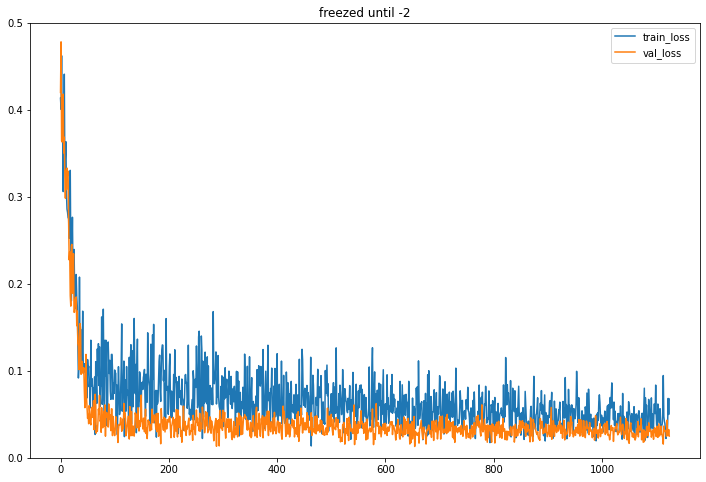

In [ ]:
plotit([train_loss, val_loss], ["train_loss", "val_loss"], y_lim=0.5, title="freezed until -2")

In [ ]:
len(train_loss), len(val_loss)

(1125, 1125)

#### save freezed weights just in case we need it later
#### in my drive so that we won't lost our file if it disconnected!

### aangus
### "drive/MyDrive/ON_PLURK/WEIGHTS" 
### chengyuan
### "drive/MyDrive/PLURK_WEIGHTS/THISONE"

#### Use gradual unfreeze folder here!

In [ ]:
"mount to my disk!"
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path
#basedir = Path("drive/MyDrive/ON_PLURK/WEIGHTS")
basedir = Path("drive/MyDrive/PLURK_WEIGHTS/THISONE")
assert basedir.is_dir()
#!ls drive/MyDrive/ON_PLURK/WEIGHTS
!ls drive/MyDrive/PLURK_WEIGHTS/THISONE # GRADUAL_UNFREEZE

Mounted at /content/drive
freezed_arch_1_epoch_2_bs_16.pt  unfreezed_arch_1_epoch_2_bs_16_lr_ng3_ng4.pt


### lower the learning rate!

#### what we need was ...
#### lr
#### optimizer
#### trainit 
#### plotit
#### save weights with filename: arch_1_unfreeze_to_$idx.pth

In [ ]:
for layers in list(model.classifier.parameters()):
  layer.requires_grad = True

for layers in list(model.classifier.parameters()):
  print(layer.requires_grad)

True
True
True
True


In [ ]:
lr

0.0001

1
epoch batches train_loss val_loss


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


0     0.044     0.0389     0.0288
0     0.089     0.0319     0.0220
0     0.133     0.0381     0.0395
0     0.178     0.0390     0.0307
0     0.222     0.0349     0.0293
0     0.266     0.0151     0.0185
0     0.311     0.0235     0.0218
0     0.355     0.0598     0.0275
0     0.400     0.0519     0.0389
0     0.444     0.0314     0.0306
0     0.489     0.0347     0.0245
0     0.533     0.0271     0.0435
0     0.577     0.0430     0.0304
0     0.622     0.0392     0.0275
0     0.666     0.0314     0.0288
0     0.711     0.0461     0.0303
0     0.755     0.0558     0.0254
0     0.799     0.0261     0.0238
0     0.844     0.0363     0.0291
0     0.888     0.0305     0.0371
0     0.933     0.0221     0.0245
0     0.977     0.0345     0.0370
2648


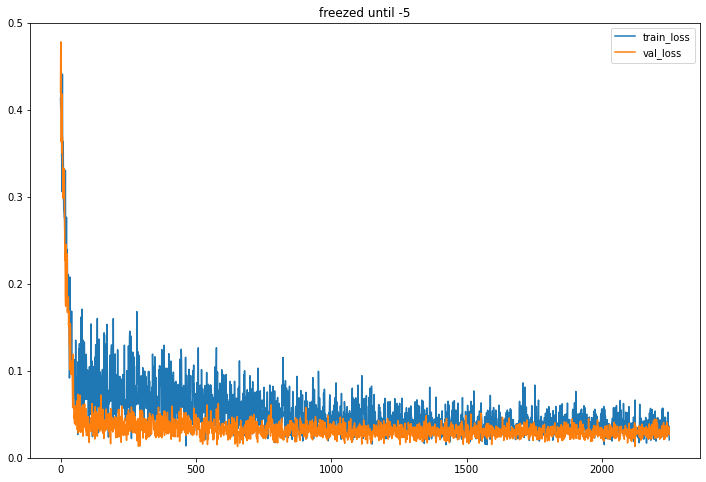

In [ ]:
print(epochs) # mostly 1

lr = 1e-4/2

optimizer = AdamW(model.parameters(), lr=lr)
optimizer.zero_grad()

loss = trainit(epochs)
loss.item()
collect()
plotit([train_loss, val_loss], ["train_loss", "val_loss"], y_lim=0.5, title="freezed until %d" % (-5))


In [ ]:
basedir = Path("drive/MyDrive/PLURK_WEIGHTS/GRADUAL_UNFREEZE")

assert basedir.is_dir()

In [ ]:
def save_weights(filename: str):
  assert filename.endswith(".pt")
  assert basedir.is_dir()
  assert not Path(basedir/filename).is_file()
  torch.save(model.state_dict(), basedir/filename)
  !ls -l drive/MyDrive/PLURK_WEIGHTS/GRADUAL_UNFREEZE

In [ ]:
!ls -l drive/MyDrive/PLURK_WEIGHTS/GRADUAL_UNFREEZE

total 0


In [ ]:
save_weights("arch_1_freeze_until_ng4_.pt")

total 320828
-rw------- 1 root root 328527085 Sep  9 19:35 arch_1_freeze_until_ng4_.pt


In [ ]:
lr

0.001

In [ ]:
"unfreeze all!"
for layer in list(model.parameters()):
  layer.requires_grad = True

for layer in list(model.parameters()):
  assert layer.requires_grad == True

In [ ]:
lr

5e-05

In [ ]:
new_lr = 1e-5
new_lr

1e-05

In [ ]:
"optimizer!"
# optimizer
optimizer = AdamW(model.parameters(), lr=new_lr)
optimizer.zero_grad()


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
collect()

3167


#### unfreeze + lowered learning rate

In [ ]:
loss = trainit(epochs)

epoch batches train_loss val_loss
0     0.044     0.0240     0.0306
0     0.089     0.0392     0.0263
0     0.133     0.0248     0.0235
0     0.178     0.0261     0.0308
0     0.222     0.0241     0.0325
0     0.266     0.0281     0.0255
0     0.311     0.0423     0.0424
0     0.355     0.0369     0.0284
0     0.400     0.0327     0.0215
0     0.444     0.0507     0.0298
0     0.489     0.0291     0.0208
0     0.533     0.0162     0.0277
0     0.577     0.0357     0.0376
0     0.622     0.0235     0.0233
0     0.666     0.0343     0.0257
0     0.711     0.0248     0.0210
0     0.755     0.0207     0.0218
0     0.799     0.0310     0.0313
0     0.844     0.0215     0.0318
0     0.888     0.0463     0.0343
0     0.933     0.0200     0.0216
0     0.977     0.0363     0.0179


In [ ]:
loss.item() # should be 'loss.item() ...'

0.030086243525147438

#### freeze + unfreeze

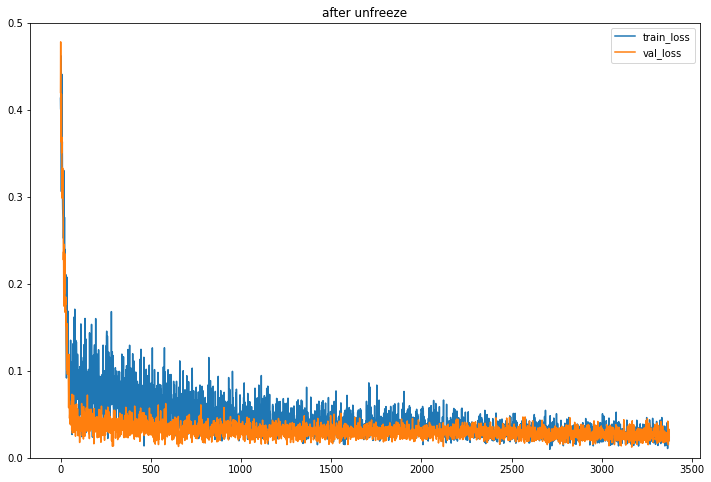

In [ ]:
plotit([train_loss, val_loss], ["train_loss", "val_loss"], y_lim=0.5, title="after unfreeze")

In [ ]:
len(train_loss), len(val_loss)

(3375, 3375)

In [ ]:
save_weights("arch1_unfreeze_all.pt")

total 641659
-rw------- 1 root root 328527085 Sep  9 19:35  arch_1_freeze_until_ng4_.pt
-rw------- 1 root root 328527085 Sep  9 20:34  arch1_unfreeze_all.pt
drwx------ 2 root root      4096 Sep  9 19:55 'baseLR=1e-5'


In [ ]:
collect()

2760


In [ ]:
loss.item()

0.030086243525147438

### Validation & Visualize

In [ ]:
testDL = get_dataloader(plurk_test, bs, True)

In [ ]:
test_loss = []
test_val_pred = []

In [ ]:
with torch.no_grad():
  model.eval()
  # test set
  for i, batch_ in enumerate(testDL):
    # (x, attn), tensor([V, A])
    (x, attn), y = batch_
    
    # output: [V, A]
    output = model.forward((x.to(device), attn.to(device)))
    loss = criterion(output, y.to(device))

    # test loss
    test_loss.append(loss.item())

    # and collect the prediction result
    # [prediction, label] for future indexing
    test_val_pred.append([output, y])

  # on val set
  for i, batch_ in enumerate(valDL):
    # (x, attn), tensor([V, A])
    (x, attn), y = batch_
    
    test_val_pred.append([output, y])


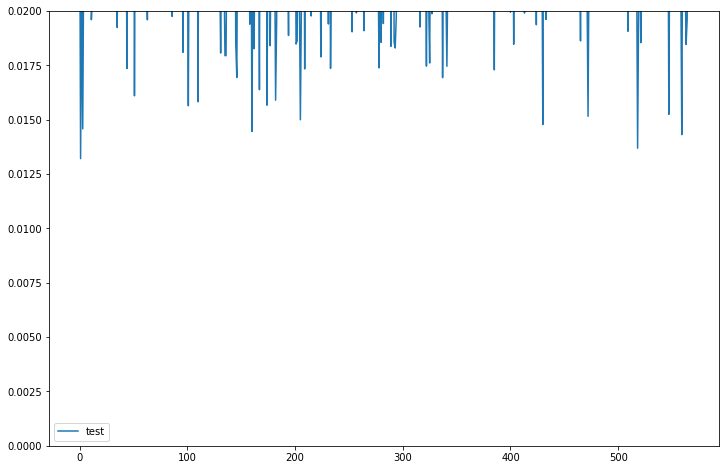

In [ ]:
plotit([test_loss], ["test"], y_lim=0.02, figsize=(12,8))

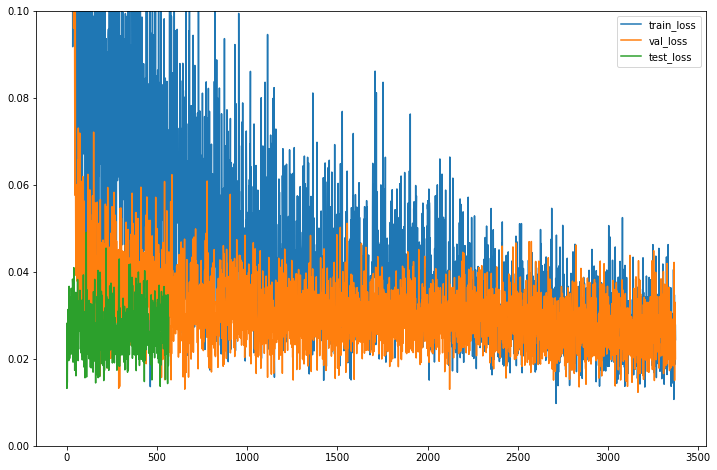

In [ ]:
plotit([train_loss, val_loss, test_loss], ["train_loss", "val_loss", "test_loss"])

## Scatter plots

In [ ]:
def sct(inp_L, legends=None, figsize=(15,10)):
  plt.figure(figsize=figsize)

  for inp in inp_L:
    idxs = inp[0]
    x_arr = inp[1]
    y_arr = inp[2]
    plt.scatter(x_arr, y_arr)
    for lb, x, y in zip(idxs, x_arr, y_arr):
      plt.annotate(lb, xy=(x,y))

  if legends is not None and isinstance(legends, list):
    plt.legend(legends)
  
  plt.show()


### change test_val_pred into predictions and labels
### predictions: list of predicted tensor([V,A])
### labels: list of label tensor([V,A]), useful in indexing (so that we know which of the emotions are more easy to predict)


In [ ]:
len(test_val_pred), len(valDL), len(testDL)

(1127, 561, 566)

In [ ]:
"process test_val_pred"
"list of [prediction, label]"
"prediction: [tensor (of bs=16)]"
"tensor (of bs=16): tensor([V,A]"
type(test_val_pred), type(test_val_pred[0]), type(test_val_pred[0][0])

(list, list, torch.Tensor)

In [ ]:
# [predict, label]
test_val_pred[0]

[tensor([[0.6172, 0.7827],
         [0.6414, 0.7958],
         [0.5924, 0.7829],
         [0.6930, 0.7694],
         [0.6655, 0.7884],
         [0.7832, 0.8214],
         [0.6357, 0.7816],
         [0.7844, 0.8356],
         [0.6996, 0.7915],
         [0.7843, 0.8067],
         [0.6626, 0.7844],
         [0.5935, 0.7720],
         [0.8193, 0.8427],
         [0.6392, 0.7934],
         [0.7677, 0.8454],
         [0.6982, 0.8159]], device='cuda:0'), tensor([[0.5441, 0.6340],
         [0.3793, 0.8553],
         [0.4547, 0.7019],
         [0.7178, 0.6365],
         [0.4547, 0.7019],
         [0.4496, 0.6918],
         [0.6616, 0.6943],
         [0.7791, 0.7031],
         [0.9693, 0.9384],
         [0.4547, 0.7019],
         [0.5441, 0.6340],
         [0.4496, 0.6918],
         [0.7803, 0.6377],
         [0.9693, 0.9384],
         [0.6641, 0.6465],
         [0.5568, 0.6453]])]

In [ ]:
# [V,A]
test_val_pred[0][0]

tensor([[0.6172, 0.7827],
        [0.6414, 0.7958],
        [0.5924, 0.7829],
        [0.6930, 0.7694],
        [0.6655, 0.7884],
        [0.7832, 0.8214],
        [0.6357, 0.7816],
        [0.7844, 0.8356],
        [0.6996, 0.7915],
        [0.7843, 0.8067],
        [0.6626, 0.7844],
        [0.5935, 0.7720],
        [0.8193, 0.8427],
        [0.6392, 0.7934],
        [0.7677, 0.8454],
        [0.6982, 0.8159]], device='cuda:0')

In [ ]:
"list of [V,A]"
_predictions = []
_labels = []

for ele in test_val_pred:
  _predictions.append(ele[0])
  _labels.append(ele[1])


In [ ]:
len(_predictions), len(_labels), len(test_val_pred)

(1127, 1127, 1127)

In [ ]:
_predictions[0]

tensor([[0.6172, 0.7827],
        [0.6414, 0.7958],
        [0.5924, 0.7829],
        [0.6930, 0.7694],
        [0.6655, 0.7884],
        [0.7832, 0.8214],
        [0.6357, 0.7816],
        [0.7844, 0.8356],
        [0.6996, 0.7915],
        [0.7843, 0.8067],
        [0.6626, 0.7844],
        [0.5935, 0.7720],
        [0.8193, 0.8427],
        [0.6392, 0.7934],
        [0.7677, 0.8454],
        [0.6982, 0.8159]], device='cuda:0')

In [ ]:
"dict of v_list, a_list"
predictions = {"V_norm": [], "A_norm": []}

# _p: batch of tensor [V,A]
for _p in _predictions:
  # each tensor in batch
  for _t in _p:
    _v, _a = _t[0], _t[1]
    predictions["V_norm"].append(float(_v))
    predictions["A_norm"].append(float(_a))


In [ ]:
len(test_val_pred),len(test_val_pred[0]),len(test_val_pred[0][0])

(1127, 2, 16)

In [ ]:
len(_predictions)

1127

In [ ]:
329*16

5264

In [ ]:
len(testDL), len(valDL)

(566, 561)

In [ ]:
# since we resample valDL, the length won't simply = len(val_pred_test)*bs
len(predictions["V_norm"])

16346

In [ ]:
"Also"
"dict of v_list, a_list"
labels = {"V_norm": [], "A_norm": []}

# _p: batch of tensor [V,A]
for _p in _labels:
  # each tensor in batch
  for _t in _p:
    _v, _a = _t[0], _t[1]
    labels["V_norm"].append(float(_v))
    labels["A_norm"].append(float(_a))

len(labels["V_norm"])

18018

In [ ]:
collect()

5554


In [ ]:
face_va.head()

,face,V,A,V_norm,A_norm
0,angryface,2.97,6.80,0.379310,0.855346
1,poutingface,2.09,7.53,0.266922,0.947170
2,facewithsymbolsonmouth,2.39,7.48,0.305236,0.940881
3,tiredface,3.01,6.70,0.384419,0.842767
4,wearyface,3.02,6.31,0.385696,0.793711


In [ ]:
"USE labels"
"get index and we're done"
"refer to label -> face_va"


'refer to label -> face_va'

In [ ]:
list(range(len(labels["A_norm"])))[:10]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
face_va.head()

,face,V,A,V_norm,A_norm
0,angryface,2.97,6.80,0.379310,0.855346
1,poutingface,2.09,7.53,0.266922,0.947170
2,facewithsymbolsonmouth,2.39,7.48,0.305236,0.940881
3,tiredface,3.01,6.70,0.384419,0.842767
4,wearyface,3.02,6.31,0.385696,0.793711


## indicies done !

In [ ]:
"answers!"
V = list(face_va["V_norm"])
A = list(face_va["A_norm"])

In [ ]:
"use labels to do indexing"
tt = labels["V_norm"][0]

In [ ]:
tt

0.5440613031387329

In [ ]:
"V.index(tt) # this will throw and error"
"-> use string to do the index"
"map the answers"
V_s = ["%.6f" % (ele) for ele in V]
A_s = ["%.6f" % (ele) for ele in A]

"map the labels as well"
"(we only need one TBH, the other is used to check the answer)"
labels_V_s = ["%.6f"%(ele) for ele in labels["V_norm"]]
labels_A_s = ["%.6f"%(ele) for ele in labels["A_norm"]]

len(labels_V_s) == len(labels_A_s)

True

In [ ]:
"we use V as index, since 0.920755 appeared twice in A"
idxs = [V_s.index(ele) for ele in labels_V_s]

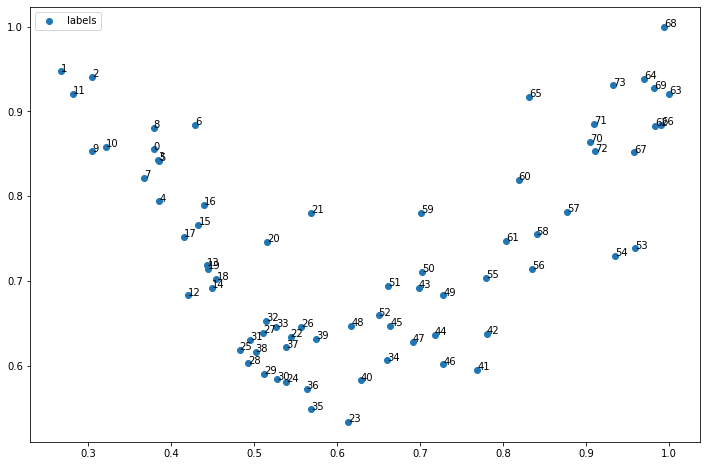

In [ ]:
plt.figure(figsize=(12,8))
x_arr = V
y_arr = A
plt.scatter(x_arr,y_arr)

for lb, x, y in zip(list(range(len(x_arr))), x_arr, y_arr):
  plt.annotate(lb, xy=(x,y))

plt.legend(["labels"])
plt.show()

In [ ]:
face_va.loc[[1]]

,face,V,A,V_norm,A_norm
1,poutingface,2.09,7.53,0.266922,0.94717


In [ ]:
face_va[["face", "V_norm", "A_norm"]].loc[[3]]

,face,V_norm,A_norm
3,tiredface,0.384419,0.842767


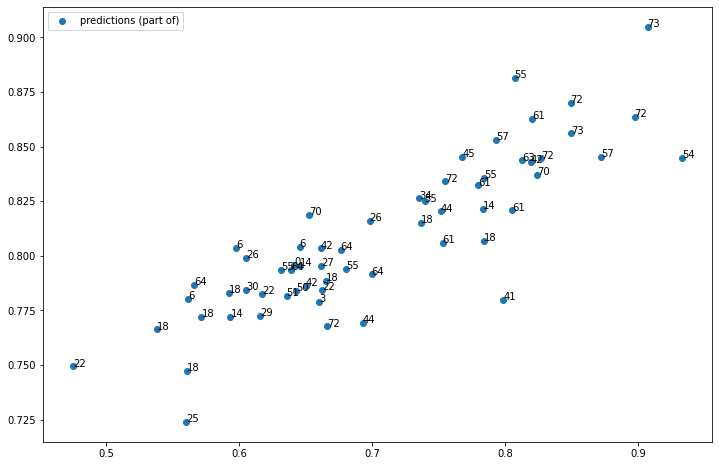

In [ ]:
plt.figure(figsize=(12,8))
x_arr = predictions["V_norm"][:60]
y_arr = predictions["A_norm"][:60]
plt.scatter(x_arr,y_arr)

for lb, x, y in zip(idxs, x_arr, y_arr):
  plt.annotate(lb, xy=(x,y))

plt.legend(["predictions (part of)"])
plt.show()

In [ ]:
face_va[["face","V_norm","A_norm"]].loc[[18, 15, 42]]

,face,V_norm,A_norm
18,cryingface,0.454662,0.701887
15,perseveringface,0.432950,0.766038
42,relievedface,0.780332,0.637736


## Combined!

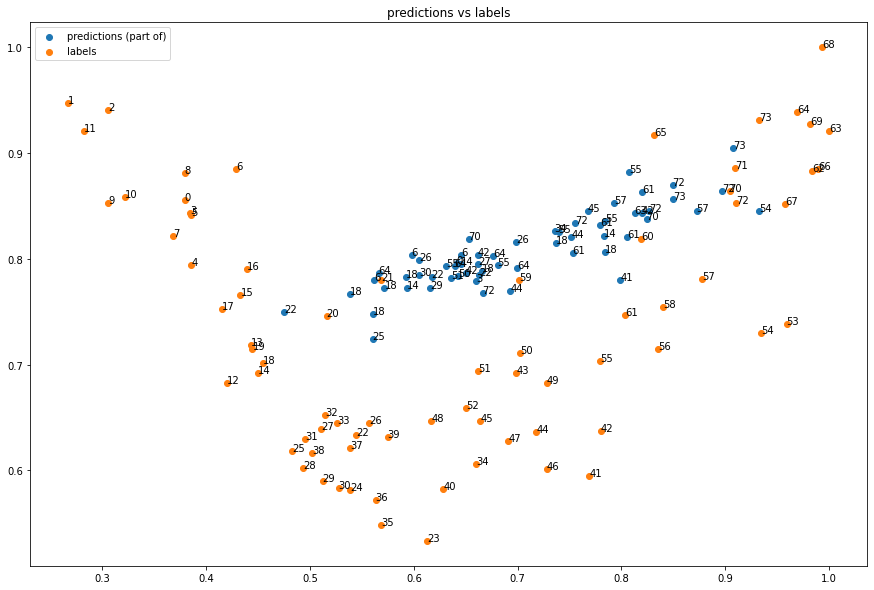

In [ ]:
plt.figure(figsize=(15,10))

x_arr = predictions["V_norm"][:60]
y_arr = predictions["A_norm"][:60]
plt.scatter(x_arr,y_arr)

for lb, x, y in zip(idxs, x_arr, y_arr):
  plt.annotate(lb, xy=(x,y))


x_arr = V
y_arr = A
plt.scatter(x_arr,y_arr)

for lb, x, y in zip(list(range(len(x_arr))), x_arr, y_arr):
  plt.annotate(lb, xy=(x,y))

plt.legend(["predictions (part of)", "labels"])
plt.title("predictions vs labels")
plt.show()

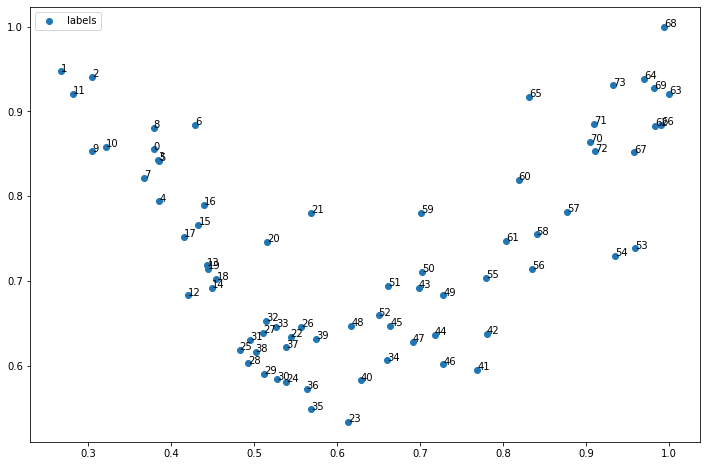

In [ ]:
plt.figure(figsize=(12,8))
x_arr = V
y_arr = A
plt.scatter(x_arr,y_arr)

for lb, x, y in zip(list(range(len(x_arr))), x_arr, y_arr):
  plt.annotate(lb, xy=(x,y))

plt.legend(["labels"])
plt.show()

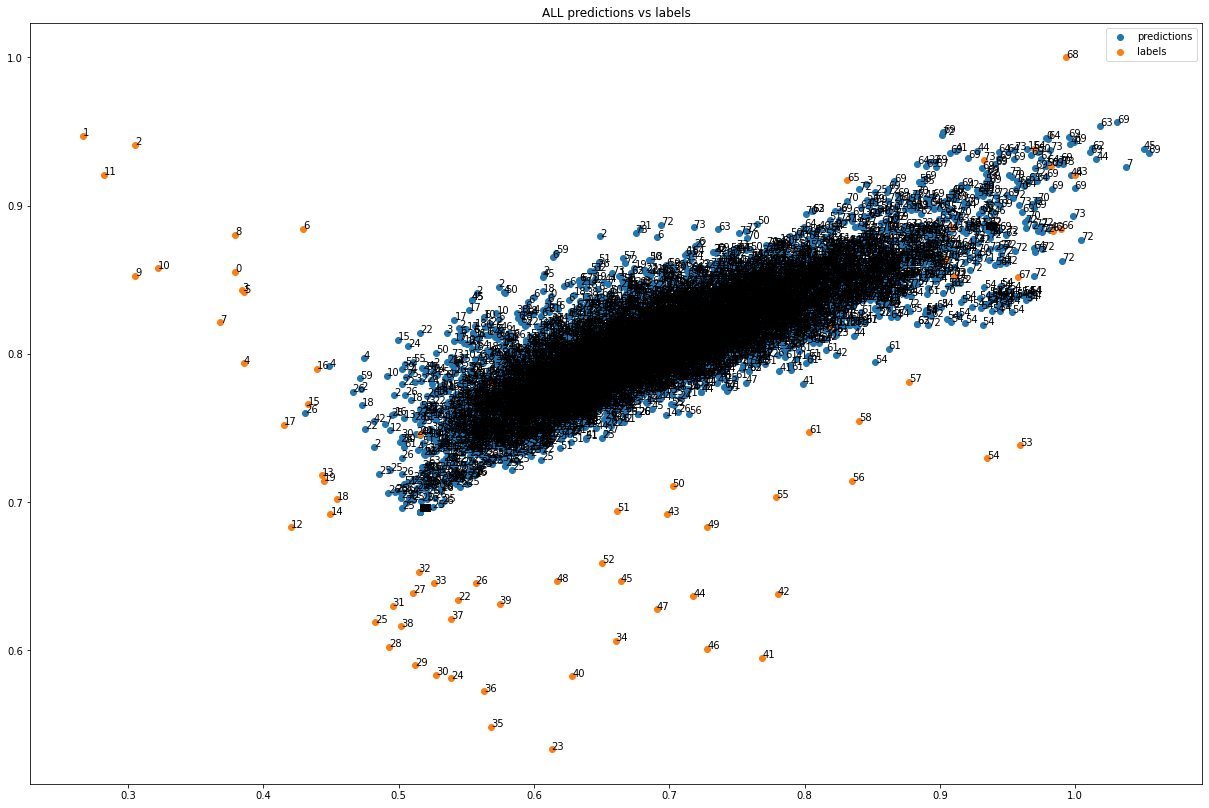

In [ ]:
"ALL"
plt.figure(figsize=(21,14))

x_arr = predictions["V_norm"]
y_arr = predictions["A_norm"]
plt.scatter(x_arr,y_arr)

for lb, x, y in zip(idxs, x_arr, y_arr):
  plt.annotate(lb, xy=(x,y))


x_arr = V
y_arr = A
plt.scatter(x_arr,y_arr)

for lb, x, y in zip(list(range(len(x_arr))), x_arr, y_arr):
  plt.annotate(lb, xy=(x,y))

plt.legend(["predictions", "labels"])
plt.title("ALL predictions vs labels")
plt.show()

In [ ]:
face_va[["face", "V_norm", "A_norm"]].loc[[27, 23, 30]]

,face,V_norm,A_norm
27,facewithraisedeyebrow,0.510856,0.638994
23,facewithoutmouth,0.613027,0.533333
30,slightlyfrowningface,0.527458,0.583648


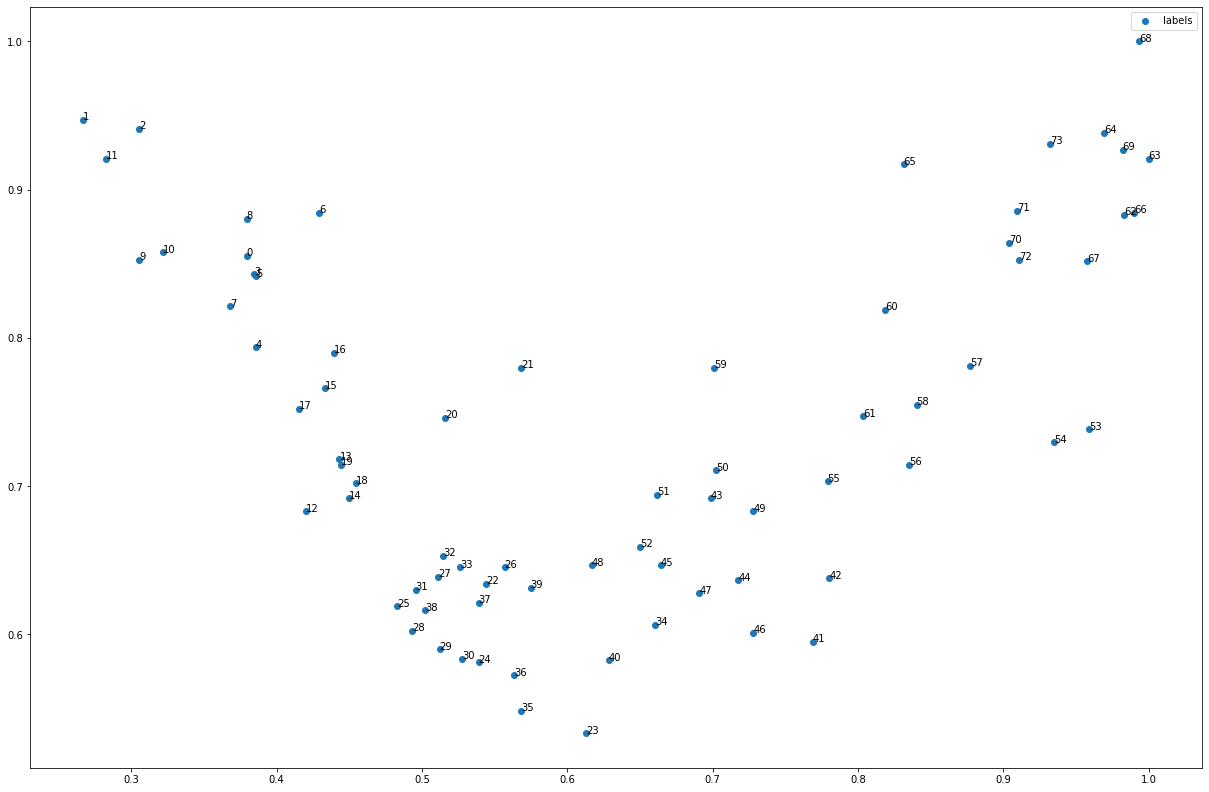

In [ ]:
plt.figure(figsize=(21,14))
x_arr = V
y_arr = A
plt.scatter(x_arr,y_arr)

for lb, x, y in zip(list(range(len(x_arr))), x_arr, y_arr):
  plt.annotate(lb, xy=(x,y))

plt.legend(["labels"])
plt.show()

## Notice that we didn't have all 74 emotions in our dataset
### , so, don't print the answers that are not in the scope

In [ ]:
len(FVA.keys())

74

In [ ]:
len(file_dict.keys())

66

In [ ]:
TO_PRINT = list(file_dict.keys())
face_va[["face"]]#.loc[TO_PRINT]

,face
0,angryface
1,poutingface
2,facewithsymbolsonmouth
3,tiredface
4,wearyface
...,...
69,smilingfacewithhearts
70,faceblowingakiss
71,kissingfacewithclosedeyes
72,partyingface


In [ ]:
TO_PRINT

['partyingface',
 'grinningfacewithsweat',
 'facewithopenmouth',
 'facewithsymbolsonmouth',
 'grinningface',
 'relieved',
 'hotface',
 'wearyface',
 'winkingface',
 'squintingfacewithtongue',
 'grinningsquintingface',
 'kissingfacewithclosedeyes',
 'facesavoringfood',
 'smilingfacewithsmilingeyes',
 'grimacingface',
 'grinningfacewithsmilingeyes',
 'nauseatedface',
 'anguishedface',
 'fearfulface',
 'faceblowingakiss',
 'angryface',
 'facewithrollingeyes',
 'facewithraisedeyebrow',
 'huggingface',
 'clownface',
 'expressionlessface',
 'facescreaminginfear',
 'kissingface',
 'sleepyface',
 'disappointedface',
 'worriedface',
 'facewithsteamfromnose',
 'sadbutrelievedface',
 'slightlyfrowningface',
 'downcastfacewithsweat',
 'facewithtongue',
 'beamingfacewithsmilingeyes',
 'confusedface',
 'cowboyhatface',
 'anxiousfacewithsweat',
 'smilingfacewithhearts',
 'tiredface',
 'facewithoutmouth',
 'kissingfacewithsmilingeyes',
 'smilingfacewithhalo',
 'slightlysmilingface',
 'explodinghead',


In [ ]:
refff = list(face_va["face"])
refff[:3]

['angryface', 'poutingface', 'facewithsymbolsonmouth']

#### If there we're key error, just keep running the next cell and you're still fine

In [ ]:
face_to_print = []
for ele in TO_PRINT:
  if ele == "perserveringface":
    ele = "perseveringface"
  elif ele == "tired" or ele == "relieved":
    ele += "face"
  elif ele == "starstruck":
    ele = "star-struck"
    
  face_to_print.append(refff.index(ele))
len(face_to_print)

ValueError: ignored

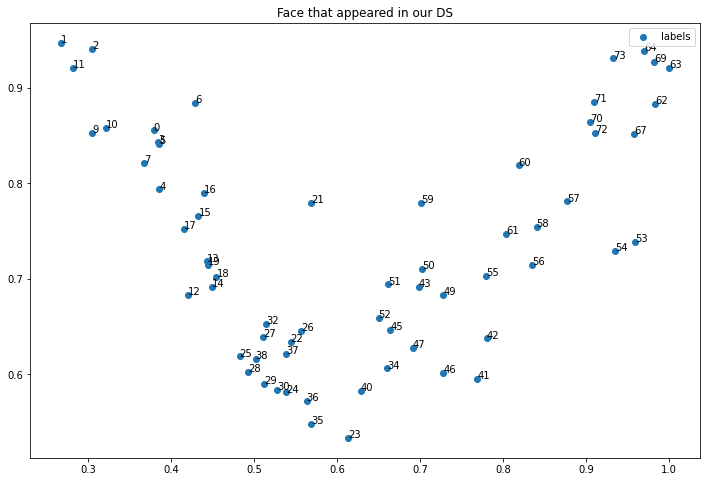

In [ ]:
plt.figure(figsize=(12,8))
x_arr = [V[e] for e in face_to_print]
y_arr = [A[e] for e in face_to_print]

plt.scatter(x_arr,y_arr)

for lb, x, y in zip(face_to_print, x_arr, y_arr):
  plt.annotate(lb, xy=(x,y))

plt.legend(["labels"])
plt.title("Face that appeared in our DS")
plt.show()

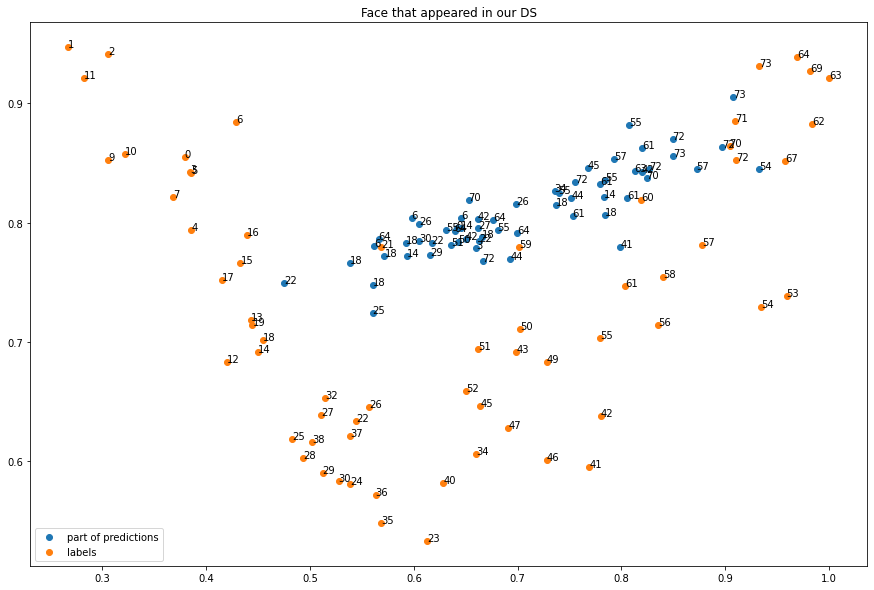

In [ ]:
"face that appeared + part of prediction"
"ALL"
plt.figure(figsize=(15,10))

x_arr = predictions["V_norm"][:60]
y_arr = predictions["A_norm"][:60]
plt.scatter(x_arr,y_arr)

for lb, x, y in zip(idxs, x_arr, y_arr):
  plt.annotate(lb, xy=(x,y))

x_arr = [V[e] for e in face_to_print]
y_arr = [A[e] for e in face_to_print]

plt.scatter(x_arr,y_arr)

for lb, x, y in zip(face_to_print, x_arr, y_arr):
  plt.annotate(lb, xy=(x,y))

plt.legend(["part of predictions", "labels"])
plt.title("Face that appeared in our DS")
plt.show()


In [ ]:
"查表: 查答案的座標"
face_va[["face", "V_norm", "A_norm"]].loc[[36, 45, 57, 0]]

,face,V_norm,A_norm
36,anguishedface,0.563218,0.572327
45,facewithmonocle,0.664112,0.646541
57,facesavoringfood,0.877395,0.781132
0,angryface,0.379310,0.855346


In [ ]:
!ls -l drive/MyDrive/PLURK_WEIGHTS/THISONE

total 641655
-rw------- 1 root root 328527085 Sep  9 17:16 freezed_arch_1_epoch_2_bs_16.pt
-rw------- 1 root root 328527085 Sep  9 18:16 unfreezed_arch_1_epoch_2_bs_16_lr_ng3_ng4.pt
